<a href="https://colab.research.google.com/github/gabrielborja/python_data_analysis/blob/main/email_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Working with mbox files

Message format <hr>
The basic Internet message format used for email is defined by RFC 5322.
Internet email messages consist of two sections, 'header' and 'body'. These are known as 'content'.
The header is structured into fields such as From, To, CC, Subject, Date, and other information about the email.
The body contains the message, as unstructured text, sometimes containing a signature block at the end. The header is separated from the body by a blank line.
More information can be found [here](https://en.wikipedia.org/wiki/Email#Header_fields)

## Uploading initial packages and data

In [1]:
#Importing preliminary packages
import numpy as np
import pandas as pd

In [ ]:
#Remove previous versions of the uploaded excel file
!rm email_list.json

In [ ]:
#Uploading file from local drive
from google.colab import files
uploaded = files.upload()

In [ ]:
#Storing json in a Pandas Dataframe
import io
df = pd.read_json(io.BytesIO(uploaded['email_list.json']), encoding='utf-8')

/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname CDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [ ]:
#Checking the dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     1480 non-null   object
 1   From     1480 non-null   object
 2   Subject  1480 non-null   object
dtypes: object(3)
memory usage: 34.8+ KB


##Initial Data cleaning

###Converting to datetime

In [ ]:
#Create a copy of the dataframe to perform data cleaning and manipulation
emails = df.copy()

In [ ]:
#Replace Unknown Timezones: i.e. CDT, CST flaged as warnings by read_json (UnknownTimezoneWarning)
emails['Date'] = emails['Date'].replace(to_replace=r'CDT|CST', value='UTC', regex=True)
#df[df['Date'].str.contains('CDT|CST', regex=True)] #==>Check how many rows contain unknown timezone

In [ ]:
#Replace invalid timezone stamps that will result in NaT values
emails['Date'] = emails['Date'].replace(to_replace='\(-05\)|\(GMT-05:00\)', value='(ECT)', regex=True)
#emails[emails['Date'].str.contains('\(-05\)|\(GMT-05:00\)', regex=True)] #==> Check how many rows contain invalid timezone

In [ ]:
#Parsing strings to datetime object and converting to Oslo time zone
emails = emails.assign(Event = emails['Date'])
emails['Event'] = pd.to_datetime(emails['Date'], errors='coerce', utc=True, format='%Y-%m-%d %H:%M:%S', infer_datetime_format=True).dt.tz_convert('Europe/Oslo')

In [ ]:
#Sorting the 'Event' column
emails = emails.sort_values(by=['Event']).reset_index(drop=True)
emails.tail()

,Date,From,Subject,Event
1475,"Mon, 07 Jun 2021 18:16:00 +0000","""Humble Bundle"" <contact@mailer.humblebundle.com>",Get Data Smart with Humble Bundle and Mercury ...,2021-06-07 20:16:00+02:00
1476,"Mon, 7 Jun 2021 13:57:53 -0500 (ECT)",banco@pichincha.com,NOTIFICACION BANCO PICHINCHA,2021-06-07 20:57:53+02:00
1477,"Mon, 07 Jun 2021 14:03:55 -0600","""Comunicados Banco Pichincha"" <comunicados@pic...",=?UTF-8?Q?Informaci=C3=B3n_de_COSEDE?=,2021-06-07 22:03:55+02:00
1478,"Mon, 07 Jun 2021 22:17:08 +0000",Diners Club del Ecuador <gestion@comunicacione...,Accede al reembolso de tus compras,2021-06-08 00:17:08+02:00
1479,"Mon, 7 Jun 2021 23:13:14 +0000 (UTC)",LinkedIn Job Recommendations <jobs-listings@li...,Harnham is looking for: Data Scientist.,2021-06-08 01:13:14+02:00


In [ ]:
#Check that the new dataframe info has all valid datetime
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype                      
---  ------   --------------  -----                      
 0   Date     1480 non-null   object                     
 1   From     1480 non-null   object                     
 2   Subject  1480 non-null   object                     
 3   Event    1480 non-null   datetime64[ns, Europe/Oslo]
dtypes: datetime64[ns, Europe/Oslo](1), object(3)
memory usage: 46.4+ KB


In [ ]:
#Checking the presence of () in date
par_date = [d for d in emails['Date'] if '(' in d]
par_date[:10]

['Tue, 25 May 2021 17:14:59 +0000 (UTC)',
 'Thu, 03 Jun 2021 05:48:41 +0000 (UTC)',
 'Sun, 6 Jun 2021 11:41:03 -0500 (ECT)',
 'Sun, 6 Jun 2021 09:02:17 -0500 (ECT)',
 'Sun, 6 Jun 2021 09:01:17 -0500 (ECT)',
 'Sun, 6 Jun 2021 08:57:38 -0500 (ECT)',
 'Fri, 21 May 2021 05:52:58 +0000 (UTC)',
 'Thu, 20 May 2021 20:12:50 +0000 (UTC)',
 'Thu, 03 Jun 2021 17:16:37 +0000 (UTC)',
 'Fri, 7 May 2021 23:51:12 +0000 (UTC)']

In [ ]:
#Checking for invalid data and timestamps in 'Event' column
emails[emails['Event'].isnull()].sum()

Date       0.0
From       0.0
Subject    0.0
Event      0.0
dtype: float64

###Transforming ASCII quoted-printable to UTF-8

Encode and Decode MIME <hr>
Many times we need to deal with data which not always has the regular ASCII characters. For example, an email in a different language other than English. Python has mechanism to deal with such characters by using MIME (Multipurpose Internet Mail Extensions) based module.

Quoted-printable in headers <hr>
The character sequence =?UTF-8?Q? is called quoted-printable, and is legitimately used to encode UTF-8 characters in internet headers, since they can contain only ASCII (rfc1342). Quoted-printable is particularly useful for when the content is mostly ASCII, so for example Chris España could be encoded as =?UTF-8?Q?Chris Espa=F1a?=



In [ ]:
#Import encode and decode MIME quoted-printable package
import quopri

In [ ]:
#Crete function to Transform 'From' and 'Subject' columns from ASCII (quoted-printable) to UTF-8

def parse_quoted_printable(df):
  """Parse from ASCII (quoted-printable) to UTF-8"""
  
  #Split data to lists
  l1_from = df['From'].copy()
  l2_subj = df['Subject'].copy()

  #Create function to decode string
  def decode_quoted(x):
    try:
      return quopri.decodestring(x).decode(encoding='utf-8')
    except UnicodeDecodeError:
      return x

  #Decode each list with quopri
  l1_from = [decode_quoted(i) for i in l1_from]
  l2_subj = [decode_quoted(i) for i in l2_subj]

  #Return dataframe with converted columns to UTF-8
  df = df.assign(From = l1_from,
                 Subject = l2_subj)

  return df

In [ ]:
#Apply function to parse from ASCII (quoted-printable) to UTF-8
emails = parse_quoted_printable(emails)

In [ ]:
#Check dataframe after ASCII text transformation
emails.head(10)

In [ ]:
#Checking how many values start with text '=?UTF-8?Q?' in 'From' column
my_utf = emails[emails['From'].str.startswith('=?')]['From'].to_list()
my_utf = [i[:10] for i in my_utf]
pd.Series(my_utf).unique()

array(['=?utf-8?Q?', '=?UTF-8?B?', '=?UTF-8?Q?', '=?iso-8859',
       '=?utf-8?B?'], dtype=object)

In [ ]:
#Checking how many unique first character are in 'From' column
begins = emails['From'].to_list()
begins = [i[:1] for i in begins]
pd.Series(begins).unique()

array(['b', 's', '=', 'S', 'R', '"', 'T', 'G', 'D', 'n', 'I', 'E', 'K',
       'A', 'C', '<', 'W', 'N', 'X', 'B', '', 'L', 'P', 'l', 'U', 'f',
       'i', 'F', 'Y', 'M', 'H', 'V', 'J', 'O', 'g', 'd', 'v', 'Q', 'z',
       'a', 'j', 'h'], dtype=object)

In [ ]:
#Use regex to replace text starting with =?utf-8?Q? =?UTF-8?Q? =?UTF-8?B? =?utf-8?B? =?iso-8859
emails['From'] = emails['From'].replace(to_replace='=\?\w*-\w[\?|\w]\w[\?|\w]', value='', regex=True)
emails['Subject'] = emails['Subject'].replace(to_replace='=\?\w*-\w[\?|\w]\w[\?|\w]', value='', regex=True)
#emails[emails['From'].str.contains('=\?\w*-\w[\?|\w]\w[\?|\w]', regex=True)]

In [ ]:
#Use regex to replace text containing =?=
emails['From'] = emails['From'].replace(to_replace='=*\?=', value='', regex=True)
emails['Subject'] = emails['Subject'].replace(to_replace='=*\?=', value='', regex=True)
#emails[emails['Subject'].str.contains('=*\?=', regex=True)]

In [ ]:
emails

In [ ]:
emails['From'][4]

'"Duolingo" <hello@duolingo.com>'

##Data Manipulation

In [ ]:
#Import regex
import re

In [ ]:
#Checkind the new dataframe head
emails.head()

In [ ]:
emails[~emails['From'].str.contains('<')]['From'].value_counts()

In [ ]:
#Create a function to parse local-part and domain

def match_local(x):
  """Match local-part from email"""
  regex1 = re.compile(r'(\w+|\w+[\.|-]\w+|\w+[\.|-]\w+[\.|-]\w+)(?:@)')
  
  try:
    m = re.findall(pattern=regex1, string=x)
    return m[0] #==> Return first group match
  except:
    return "No match"

def match_sender(x):
  """Match name of sender from email"""
  regex2 = re.compile(r'(.*?)(?:<)')
  
  try:
    m = re.findall(pattern=regex2, string=x)
    return m[0].strip().replace('"', '') #==> Return first group match and strip space and "
  except:
    return "No Sender"

def match_domain(x):
  """Match name of domain from email"""
  regex3 = re.compile(r'(?:@)(.*)(?:\.)')
  
  try:
    m = re.findall(pattern=regex3, string=x)
    return m[0].strip().replace('"','').replace("?",'').replace(">",'') #==> Return first group match and strip space and "
  except:
    return "No Domain"

In [ ]:
#Define a regex function to match sender, local-part and domain
def regex_matcher(x, reg_ex):
  """Match regular expression argument"""
  try:
    m = re.findall(pattern=reg_ex, string=x)
    return m[0].strip().replace('"','').replace("?",'').replace(">",'') #==> Return first group match, strip space and invalid char
  except:
    return None

In [ ]:
#Compile regular expressions and apply regex_matcher
regex1 = re.compile(r'(.*?)(?:<)') #==> Match sender
regex2 = re.compile(r'(\w+|\w+[\.|-]\w+|\w+[\.|-]\w+[\.|-]\w+)(?:@)') #==> Match local-part
regex3 = re.compile(r'(?:@)(.*)(?:>?)') #==> Match domain

emails = emails.assign(Sender = emails['From'].apply(regex_matcher, args=(regex1,)),
                       Local_part = emails['From'].apply(regex_matcher, args=(regex2,)),
                       Domain = emails['From'].apply(regex_matcher, args=(regex3,)))
emails.head(10)

In [ ]:
#senders = emails['Sender'].value_counts().reset_index()['index'].to_list()
#senders
emails['Sender'].value_counts()

In [ ]:
emails['Local_part'].value_counts()

In [ ]:
emails['Domain'].value_counts()

In [ ]:
#Replace None value for "N/A" in sender column
emails['Sender'] = np.where(emails['Sender'].isnull(), 'N/A', emails['Sender'])

In [ ]:
#Replace None values in Local_part with H.Watt
emails['Sender'] = np.where(emails['Local_part'].isnull(), 'The Watt Club', emails['Sender'])
emails['Local_part'] = np.where(emails['Local_part'].isnull(), 'watt.club', emails['Local_part'])
emails['Domain'] = np.where(emails['Domain'].isnull(), 'hw.ac.uk', emails['Domain'])

In [ ]:
#Verify that missing data was cataloged
emails[emails['Sender'].str.contains('Watt')]

In [ ]:
#Exporting df to csv in local disk
from google.colab import files
emails.to_csv('emails.csv', index=False)
files.download('emails.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Data Visualization

###Importing data and packages

In [2]:
#Import visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Uploading file from local drive
from google.colab import files
uploaded1 = files.upload()

In [4]:
#Storing csv in a Pandas Dataframe
import io
emails = pd.read_csv(io.BytesIO(uploaded1['emails.csv']), parse_dates=True)

In [5]:
#Convert Event into datetime and Oslo time zone
emails['Event'] = pd.to_datetime(emails['Event'], errors='coerce', utc=True, format='%Y-%m-%d %H:%M:%S', infer_datetime_format=True).dt.tz_convert('Europe/Oslo')

In [6]:
#Select columns to store in a dataframe for visualization
em_df = emails[['Event', 'Sender', 'Local_part', 'Domain']].copy()
em_df.tail(4)

,Event,Sender,Local_part,Domain
1476,2021-06-07 20:57:53+02:00,NaN,banco,pichincha.com
1477,2021-06-07 22:03:55+02:00,Comunicados Banco Pichincha,comunicados,pichincha.com
1478,2021-06-08 00:17:08+02:00,Diners Club del Ecuador,gestion,comunicaciones.dinersclub.com.ec
1479,2021-06-08 01:13:14+02:00,LinkedIn Job Recommendations,jobs-listings,linkedin.com


In [7]:
#Check the dataframe information
em_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype                      
---  ------      --------------  -----                      
 0   Event       1480 non-null   datetime64[ns, Europe/Oslo]
 1   Sender      1301 non-null   object                     
 2   Local_part  1480 non-null   object                     
 3   Domain      1480 non-null   object                     
dtypes: datetime64[ns, Europe/Oslo](1), object(3)
memory usage: 46.4+ KB


In [8]:
#Create a function to extract categories from datetime like year, month, week number, day and hour
def categories_from_datetime(df):
  """Extract year, month, day, hour and minutes from datetime column"""
  df = df.assign(year = df.iloc[:,0].dt.year,
                 month = df.iloc[:,0].dt.month,
                 weeknum = df.iloc[:,0].dt.isocalendar().week,
                 day = df.iloc[:,0].dt.day_name(),
                 hour = df.iloc[:,0].dt.hour,
                 )
  return df

In [9]:
#Extracting categories from datatime object
em_df = categories_from_datetime(em_df)
em_df.head()

,Event,Sender,Local_part,Domain,year,month,weeknum,day,hour
0,2019-10-09 23:03:38+02:00,NaN,banco,pichincha.com,2019,10,41,Wednesday,23
1,2019-10-10 11:55:06+02:00,NaN,servicios,titanium.com.ec,2019,10,41,Thursday,11
2,2019-10-13 20:38:34+02:00,NaN,bancavirtual,bancoguayaquil.com,2019,10,41,Sunday,20
3,2019-10-13 21:29:31+02:00,NaN,bancavirtual,bancoguayaquil.com,2019,10,41,Sunday,21
4,2019-10-15 10:11:07+02:00,"Øyvind_Grimstad,_BearingPoint",conversations,email.teamtailor.com,2019,10,42,Tuesday,10


In [10]:
#Dropping year 2019
em_df = em_df[em_df['year']!=2019]

###Emails by month

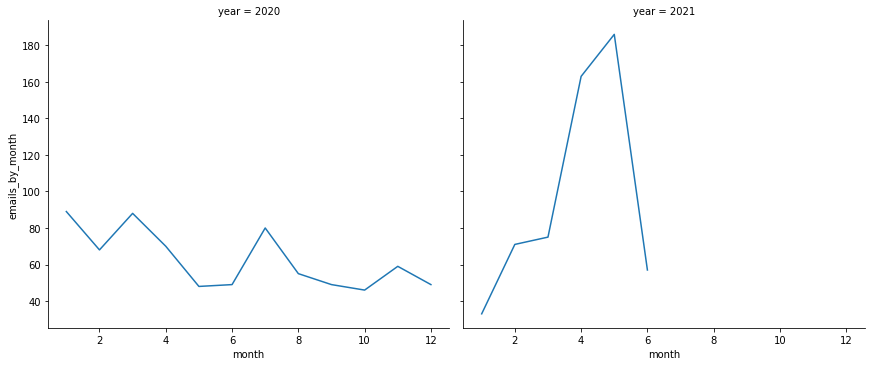

In [12]:
#Emails by month
month_df = em_df.groupby(['year', 'month']).agg(emails_by_month=('day', 'count')).reset_index()
sns.relplot(x='month', y='emails_by_month', col='year', data=month_df, kind='line', height=5, aspect=1.2)
plt.show()

###Emails by day of week

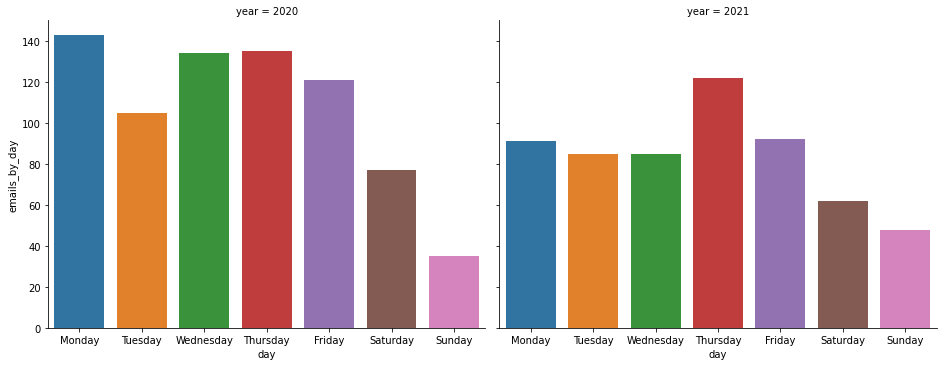

In [13]:
#Emails by day of the week
day_col = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = em_df.groupby(['year', 'day']).agg(emails_by_day=('hour', 'count')).reset_index()
sns.catplot(x='day', y='emails_by_day', col='year', order=day_col, data=day_df, kind='bar', height=5, aspect=1.3)
plt.show()

###Average hour of emails by day of the week

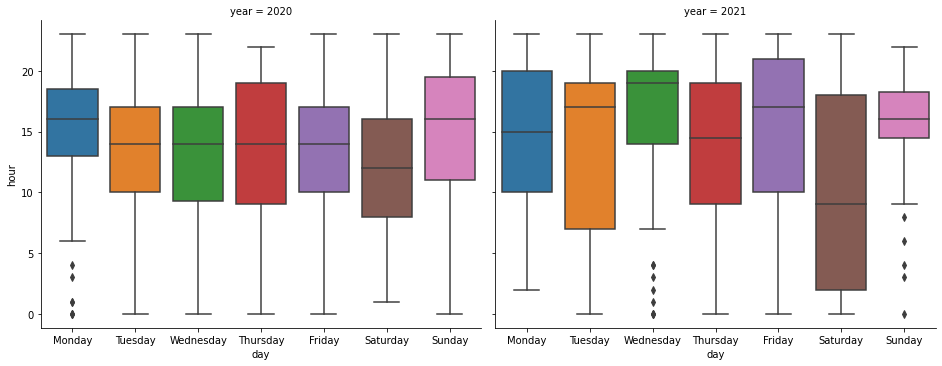

In [19]:
#Average hour of emails by day of the week
sns.catplot(x='day', y='hour', col='year', order=day_col, data=em_df, kind='box', height=5, aspect=1.3)
plt.show()

###Emails by hour of the day

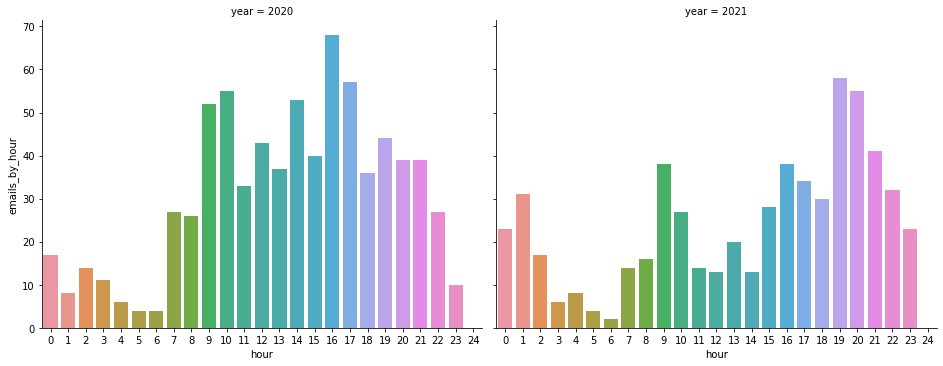

In [20]:
#Emails by hour of the day
hr_col = [i for i in range(0, 25)]
hr_df = em_df.groupby(['year', 'hour']).agg(emails_by_hour=('day', 'count')).reset_index()
sns.catplot(x='hour', y='emails_by_hour', col='year', order=hr_col, data=hr_df, kind='bar', height=5, aspect=1.3)
plt.show()